# Simple Source Time Function Inversion
#### Written by James Smith, Ph.d
##### Modified by Lucas Sawade

The method uses observed data (processed according to FieldDataProcessing.ipynb)
and synthetic data (from SPECFEM3D) and applies a simple linear inversion formula:

\begin{equation}
S(\omega)^{*} = \frac{u^{t}d^{*}}{u^{t}u^{*}}
\end{equation}

where u is the simulated wavefield and d is the observed wavefield.

## Load Observed and Synthetic Wavefield

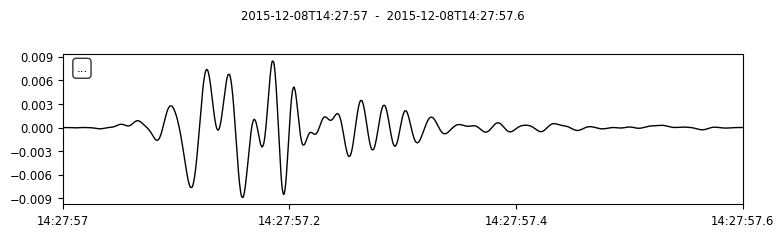

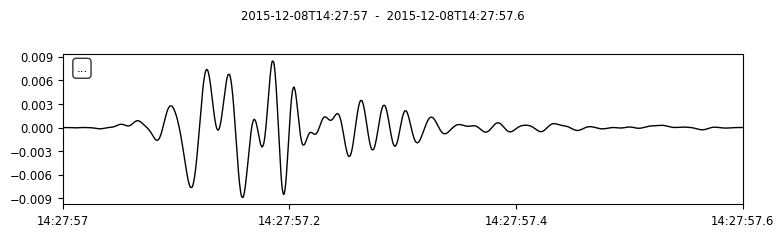

In [146]:
%matplotlib inline
import matplotlib.pyplot as plt
from obspy import read, UTCDateTime

# First we read in the observed and synthetic data and plot a single trace
# Load traces. [SU == Seismic Unix?]
field_obs = read('./data/observed', unpacked_headers=True)     # processed field data (720 traces)
specfem3d_syn = read('./data/0_dz_SU', unpacked_headers= True) # Green's function from SPECFEM3D (720 traces)

# I don't know what's happening here... Are there multiple traces?
field_trace = field_obs.traces[40] # Trace about ~10 m away from source
syn_trace = specfem3d_syn.traces[40] # Trace about ~10 m away from source

# Process synthetic traces
beginTime = UTCDateTime(syn_trace.stats.starttime)
syn_trace.trim(beginTime, beginTime+0.6)
syn_trace.detrend('constant')
syn_trace.taper(max_percentage=0.05,type='cosine')


# Process observed traces
beginTime = UTCDateTime(field_trace.stats.starttime)
field_trace.trim(beginTime, beginTime+0.6)
field_trace.detrend('constant')
field_trace.taper(max_percentage=0.05,type='cosine')

# Plot both traces
syn_trace.plot();
field_trace.plot();

## Setup Cosine taper to filter the traces:

We now generate the frequency filter that has already been applied ot the processed field data. We plot the filter to verify.

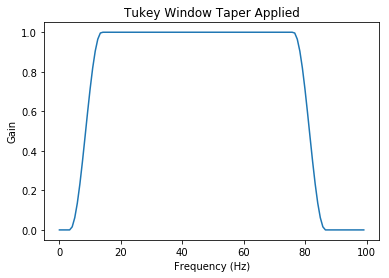

In [147]:
import numpy as np
from scipy import signal
from obspy.signal.util import _npts2nfft
from scipy.fftpack import fft, ifft, fftfreq

# Setup prefilter with cosine taper
npts = len(field_trace.data) # resampled trace so different from FieldDataProcessing
nfft = _npts2nfft(npts)

freq_pos = signal.tukey(101, alpha=0.25)
freq_pos = np.pad(freq_pos, 4,'constant',constant_values=0)
freq_pos.resize(int(nfft/2))
freq_neg = freq_pos[::-1]
syn_taper = np.append(freq_pos, freq_neg)

# Plot the filter
dt = 0.0003 # Sample spacing
freqs = fftfreq(nfft, d=dt)
plt.plot(freqs[0:120],freq_pos[0:120])
plt.title('Tukey Window Taper Applied')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain');

## Change into the Frequency Domain

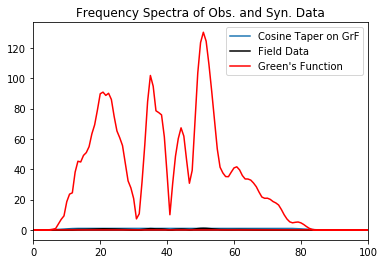

In [148]:
# Normalize the synthetic data
syn_trace.data /= max(syn_trace.data) 

# Taper the synthetic data in the frequency domain
fftsyn = fft(syn_trace.data, n=nfft)
fftsyn *= syn_taper

# Normalize field data?
# field_trace.data/= max(field_trace.data)

fftfield = fft(field_trace.data, n=nfft) # What are we not normalizing the field traces?


# Plot the spectrums
plt.figure()
plt.title("Frequency Spectra of Obs. and Syn. Data")
plt.plot(freqs,syn_taper, label="Cosine Taper on GrF")
plt.plot(freqs,np.abs(fftfield), color="black", label="Field Data")
plt.plot(freqs,np.abs(fftsyn), color="red", label="Green's Function")
plt.xlim([0, 100])
plt.legend();

## Source Time Function Inversion

Now, we use the synthetic and the observed data to invert for the source time function in the frequency domain.

In [149]:
# Create empty complex array
stf = np.zeros(fftsyn.shape, dtype=np.complex)

# Number of elements in frequency vector to be considered
n_el = 100

# Find where synthetics are non-zero
posnz = np.nonzero(np.abs(fftsyn[0:n_el]))

# Find elements of synthetics that are zero
posz = np.where(fftsyn[0:n_el])

# Invert for sourcetimefunction
stf[posnz] = (fftsyn[pos].T*fftfield[pos].conj().T)/(fftsyn[pos].T*fftsyn[pos].conj().T)

stf = stf.conj().T

73


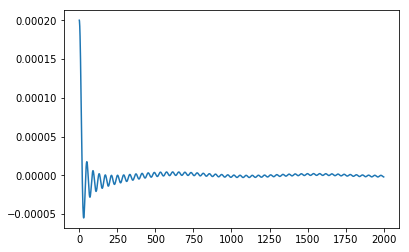

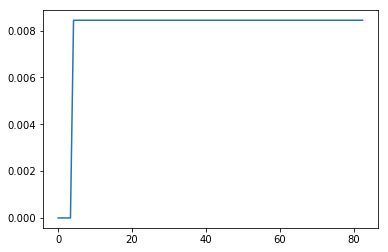

In [150]:

# Setup prefilter with cosine taper
#npts = len(syn_trace.data)
#nfft = _npts2nfft(npts)
freqindex = np.where(freqs>60)
print(freqindex[0][0])
freq_pos = signal.tukey(101, alpha=0.25)
freq_pos = np.pad(freq_pos, 4,'constant',constant_values=0)
freq_pos.resize(int(nfft/2))
#freq_pos = np.roll(freq_pos, 4)
freq_neg = freq_pos[::-1]
freq_taper = np.append(freq_pos, freq_neg)
# Plot the filter
freqs = fftfreq(nfft, d=0.0003)
# filter with cosine taper
stf *= freq_taper
#tf *= freq_taper
#stf *= syn_taper
plt.plot(np.real(ifft(stf,n=nfft)[0:npts]))
plt.figure()
plt.plot(freqs[0:100], np.abs(stf[0:100]))
# plt.legend(['Taper Applied', 'STF after applying Taper'])

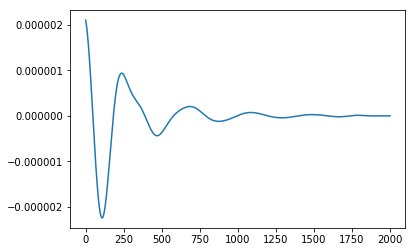

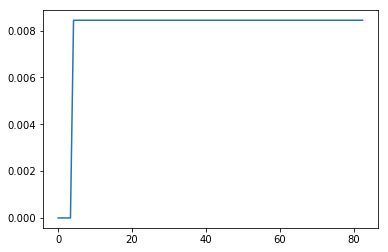

In [153]:
from obspy import Trace
st = Trace(data=ifft(stf,n=nfft)[0:npts])
st.stats.delta=0.0003
st.taper(max_percentage=0.05,type='hann')
st.filter('bandpass',freqmin=8,freqmax=20,zerophase=True)
plt.plot(st)
plt.figure()
plt.plot(freqs[0:100], np.abs(stf[0:100]))

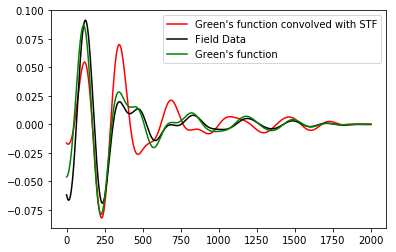

In [154]:
# Now convolve the source with the Green's Function
from obspy.core import Trace
from numpy.fft import *
#ik = np.array([2j*np.pi*k for k in xrange(0, nfft)])/ nfft
#fshift = np.exp(-ik*52)
syn_trace = specfem3d_syn.traces[4] # Trace about ~10 m away from source
beginTime = UTCDateTime(syn_trace.stats.starttime)
syn_trace.trim(beginTime, beginTime+0.6)
syn_trace.detrend('constant')
syn_trace.taper(max_percentage=0.05,type='cosine')
w = np.linalg.norm(syn_trace.data, ord=2)
syn_trace.data /= w
fftsyn = fft(syn_trace.data, n=nfft)
fftsyn *= syn_taper
#stf *= syn_taper
st = Trace(data=ifft(stf,n=nfft)[0:npts])
st.stats.delta=0.0003
st.detrend('demean')
st.taper(max_percentage=0.05,type='hann')
st.filter('bandpass',freqmin=8,freqmax=20,zerophase=True)
convolved_Green=ifft(fftsyn*fft(st.data,n=nfft), n=nfft)[0:npts]
synGreen = Trace(data=convolved_Green)
synGreen.stats.delta=0.0003
#plt.plot(ifft(stf,n=nfft)[0:npts])
synGreen.filter('bandpass',freqmin=8,freqmax=20,zerophase=True)
w = np.linalg.norm(synGreen.data, ord=2)
synGreen.data /= w
plt.plot(synGreen, color="red")
field_trace = field_obs.traces[4] # Trace about ~10 m away from source
field_trace.filter('bandpass',freqmin=8,freqmax=20,zerophase=True)
w = np.linalg.norm(field_trace.data, ord=2)
field_trace.data /= w
plt.plot(field_trace, color="black")
syn_trace.filter('bandpass',freqmin=8,freqmax=20,zerophase=True)
w = np.linalg.norm(syn_trace.data, ord=2)
syn_trace.data /= w
plt.plot(syn_trace,color="green")
plt.legend(["Green's function convolved with STF", "Field Data", "Green's function"])
plt.savefig('compare.pdf')